<a href="https://www.kaggle.com/code/kmk3593/test2?scriptVersionId=92436554" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Spaceship Titanic 데이터를 활용한 탑승유무 분류모형 개발
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 강사명 : Evan
- 수강생명 : 김민균

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


### 문제 파악
- 타이타닉 우주선이 시공간 변칙성과 충돌했다.
- 그 안에 타고 있던 13000명의 승객 중 절반이 사고에 의하여 다른 차원으로 이송되었다.
- 손상된 컴퓨터 시스템에서 복구된 기록을 사용해 어떤 승객이  운송되었는지 예측해야 한다.
- 본인의 임무는 우주선 타이타닉이 시공간 이상과 충돌하는 동안 승객이 다른 차원으로 이송되었는지 여부를 예측하는 것이다.

### 파일 및 데이터 필드
- train.csv - 훈련 데이터로 사용되는 승객의 약 2/3(~8700)에 대한 개인 기록.
   - PassengerId- 각 승객에 대한 고유 ID. 각 ID는 승객이 함께 여행하는 그룹 gggg_pp을 gggg나타내며 pp는 그룹 내 번호. 
       - 그룹의 사람들은 보통 가족 구성원이지만 항상 그런 것은 아니다.
   - HomePlanet- 승객이 출발한 행성, 일반적으로 영구 거주 행성.
   - CryoSleep- 승객이 항해 기간 동안 정지된 애니메이션에 놓이도록 선택했는지 여부를 나타낸다. cryosleep의 승객은 객실에 국한된다.
   - Cabin- 승객이 머물고 있는 객실 번호. Deck/num/side 형식을 취하며, 여기에서 side는 Port의 경우 P 또는 Starboard의 경우 S일 수 있다.
   - Destination- 목적지
   - Age- 승객의 나이.
   - VIP- 승객이 항해 중 특별 VIP 서비스를 지불했는지 여부.
   - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 우주선 타이타닉의 다양한 고급 편의 시설에 대해 청구한 금액.
   - Name- 승객의 성과 이름.
   - Transported- 승객이 다른 차원으로 이송되었는지 여부. 이것은 예측하려는 대상인 열.
- test.csv - 테스트 데이터로 사용되는 나머지 승객의 1/3(~4300)에 대한 개인 기록. Transported당신의 임무는 이 세트에 있는 승객의 가치를 예측하는 것.
- sample_submission.csv - 올바른 형식의 제출 파일.
 - PassengerId- 테스트 세트의 각 승객에 대한 ID.
 - Transported- 목표. 각 승객에 대해 True 또는 False를 예측.

# Step1. 라이브러리 및 데이터 불러오기
- 본 프로젝트 수행을 위한 필수 라이브러리를 불러온다.
- 라이브러리 버전 확인

In [2]:
# 데이터 가공
import numpy as np
import pandas as pd

# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 버전 확인
print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("seaborn version: ", sns.__version__)

numpy version:  1.20.3
pandas version:  1.3.5
matplotlib version:  3.5.1
seaborn version:  0.11.2


- 이번에는 주어진 데이터를 불러온다.
- 훈련데이터는 8,693개, 테스트 데이터는 4,277개로 구성되어 있다.
- 독립변수 컬럼 갯수는 13개며,종속 변수는 1개로 구성되어 있다.

In [3]:
# Data Loading and Preparation

train_data = pd.read_csv("../input/spaceship-titanic/train.csv")
test_data = pd.read_csv("../input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

train_data.shape, test_data, sample_submission.shape

((8693, 14),
      PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
 0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
 1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
 2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
 3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
 4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
 ...          ...        ...       ...       ...            ...   ...    ...   
 4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
 4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
 4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
 4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
 4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   
 
       RoomService  FoodC

- train_data에 대해 살펴본다.
- 먼저, 결측치가 있는 코드들이 있지만, 전체적을 많은 편은 아니다.
- bool(1), float64(6), object(7)개로 구성이 되어 있다.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


- 테스트 데이터도 마찬가지로 비슷한 양상을 나타냄.

In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


- 예측해야 할 종속변수는 Transported인 것으로 확인됨.

In [6]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


- 데이터 컬럼 확인
    - 각 데이터의 특성을 파악하기 위해서는 해당 설명서를 참조하는 것이 좋음
    - 출처 : https://www.kaggle.com/competitions/spaceship-titanic/data

- 대화주제
    - Transported Column 설명을 보면, 다른 차원으로 이동하기 위한, 각 승객의 탑승을 했는지 못했는지를 예측하는 문제이며, 평가지표는 정확도로 판정함.
- 분류 정확도(Classification Accuuracy)의 설명은 Classification Accuracy에서 확인할 수 있다.

# Step2. 탐색적 자료 분석 (EDA)
- 데이터 시각화
- 산점도, 막대 그래프 등
- 그래프 해석해서 설명을 달아야 함
- 약간의 데이터 전처리

### 데이터 시각화를 위한 주요 함수 작성
- 훈련데이터의 구조는 다음과 같다.
    - dtypes : bool(1), float(64), object(7)
- 우선, 종속변수인 bool의 갯수에 대해 확인한다.
- 갯수로 파악할 때는 비율은 큰 차이가 없는 것으로 확인했다. 즉, 데이터는 매우 균등하게 구성이 된 것이다.

In [7]:
train_data['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [8]:
train_data['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

- 시각화 코드

In [9]:
def cnt_bar(data, col_name):
    df = data[col_name].value_counts()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = [str(item) for item in list(data[col_name].value_counts().index)]
    bars = sns.countplot(x=col_name, data=data, color='lightgray', alpha=0.85, zorder=2, ax=ax)
    
    for bar in bars.patches:
        fontweight = "normal"
        color = "k"
        height = np.round(bar.get_height(), 2)
        if bar.get_height() == data[col_name].value_counts().values[0]:
            fontweight="bold"
            color="orange"
            bar.set_facecolor(color)
        ax.text(bar.get_x() + bar.get_width()/2., height+100, height+1, ha='center', size=12, fontweight=fontweight, color=color)
    ax.set_title(f'Bar Graph of {col_name}', size=16)
    ax.set_xlabel(col_name, size=16)
    ax.set_ylabel("No. Passengers", size=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(("outward", 20))
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.grid(axis="y", which="major", color="lightgray")
    ax.grid(axis="y", which="major", ls=":")
    
    plt.show()

- 이제 함수를 적용해본다.
    - Cabin이나,PassengerID 등에는 적용할 수 없다.

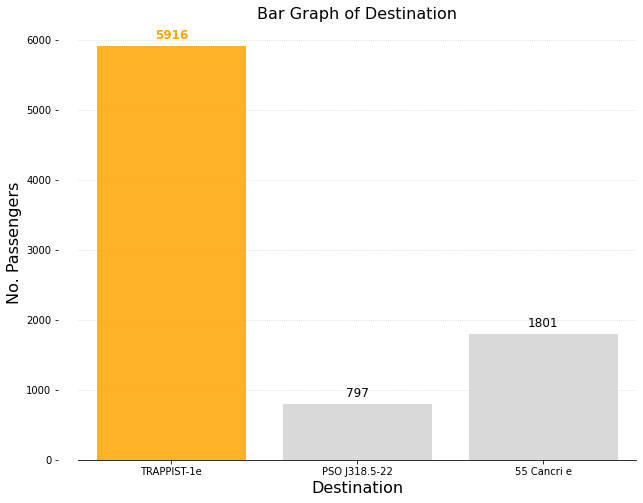

In [10]:
cnt_bar(train_data, "Destination")

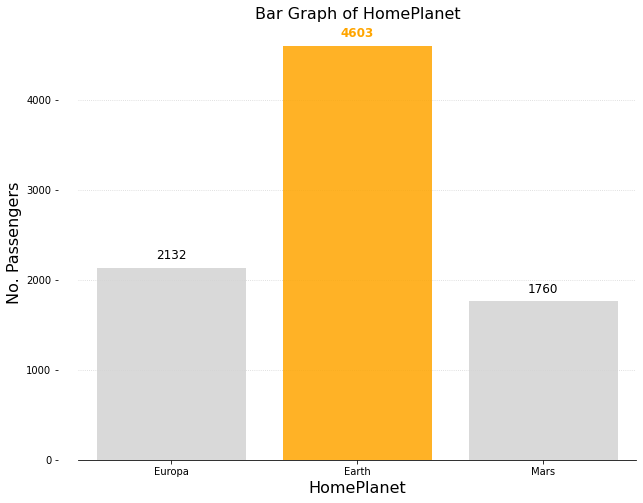

In [11]:
cnt_bar(train_data, "HomePlanet")

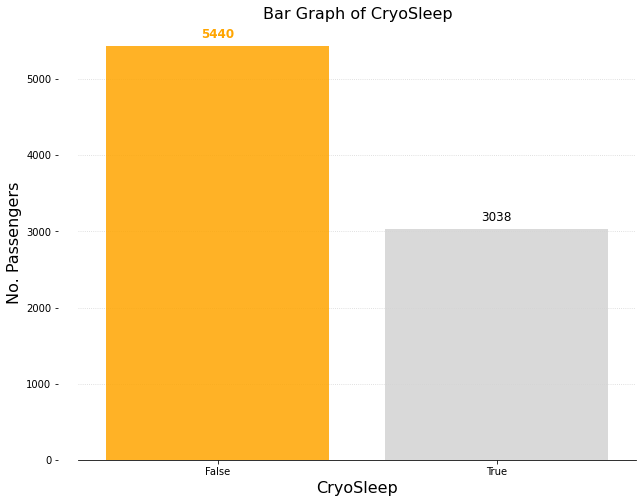

In [12]:
cnt_bar(train_data, "CryoSleep")

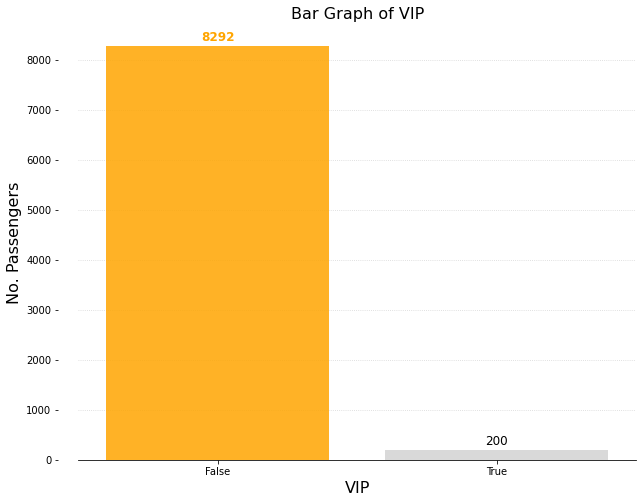

In [13]:
cnt_bar(train_data, "VIP")

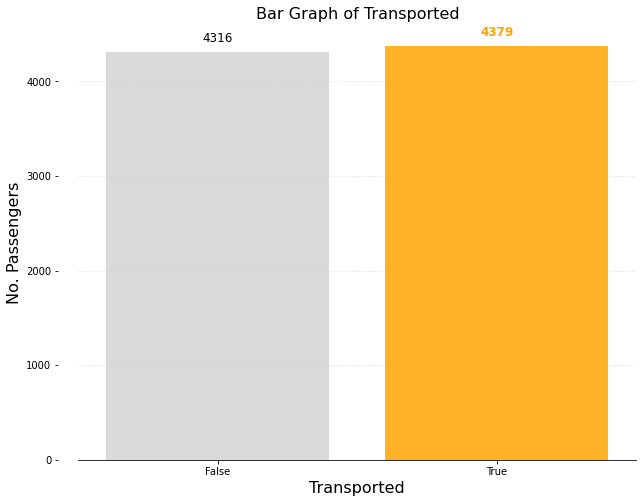

In [14]:
cnt_bar(train_data, "Transported")

- 이번에는 Describe()함수를 적용해본다.

In [15]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [16]:
numeric_features = train_data.select_dtypes(include=[np.number])
numeric_features.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

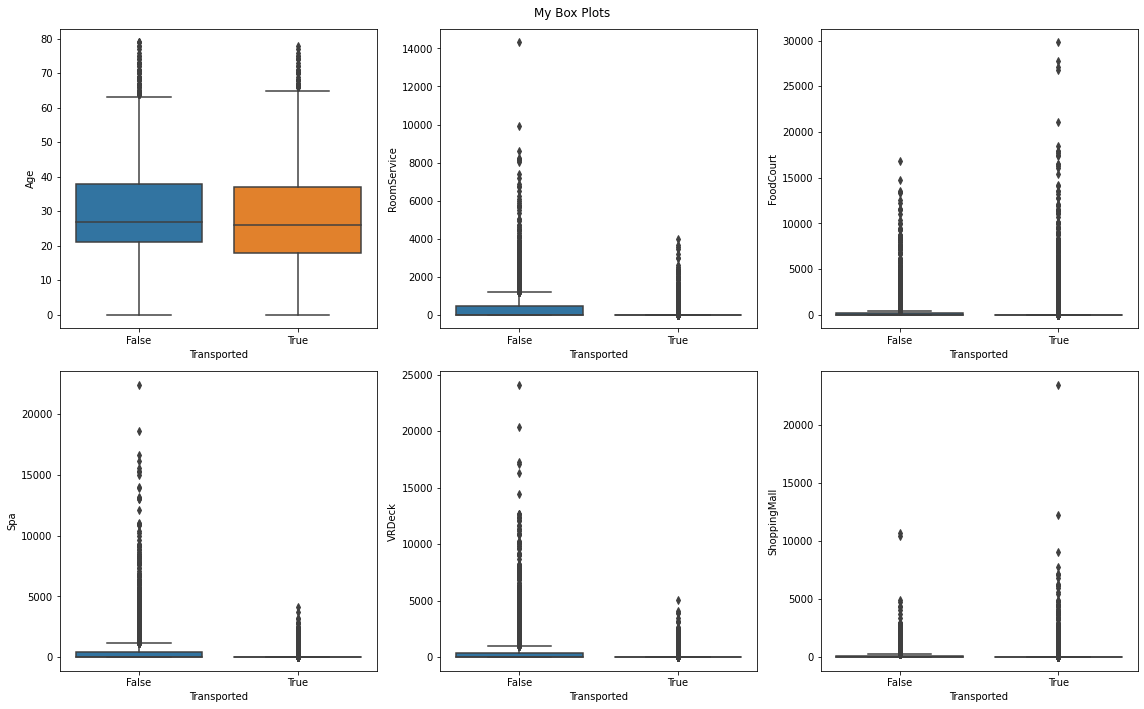

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))# 그래프의 행과 열 지정 및, 이미지 사이즈 지정
data = train_data.copy()
#data[numeric_features.columns].columns[0:]
for i, col in enumerate(data[numeric_features.columns].columns[0:]):  # 좌표 평면 지정
    # print(i, col)
    if i <= 2:
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[0,i]) # 1행 좌표 평면
    else:
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[1, i-4]) # 5행 좌표 평면
fig.suptitle('My Box Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

- 위 시각화 결과물을 놓고 보면, RoomService, FoodCourt, Spa, VRDeck, ShoppingMall은 수치가 아닌 것처럼 보인다.

In [18]:
train_data['RoomService'].value_counts()

0.0       5577
1.0        117
2.0         79
3.0         61
4.0         47
          ... 
1612.0       1
2598.0       1
632.0        1
378.0        1
745.0        1
Name: RoomService, Length: 1273, dtype: int64

In [19]:
train_data['FoodCourt'].value_counts()

0.0       5456
1.0        116
2.0         75
3.0         53
4.0         53
          ... 
3846.0       1
5193.0       1
312.0        1
827.0        1
4688.0       1
Name: FoodCourt, Length: 1507, dtype: int64

In [20]:
train_data['Spa'].value_counts()

0.0       5324
1.0        146
2.0        105
5.0         53
3.0         53
          ... 
273.0        1
2581.0       1
2948.0       1
3778.0       1
1643.0       1
Name: Spa, Length: 1327, dtype: int64

- 실제 컬럼명에서 말하는 것도 다음과 같음.
    - RoomService, FoodCourt, ShoppintMall, Spa, VRDeck-Amount the passenger has billed at each of the Spaceship Titanic's many
- 즉, 위 데이터는 연속형 데이터라고 보기에는 비연속형 수치 데이터인 것을 확인.

# Step3. 데이터 전처리
- Feature Engineering 이라고도 한다
- ML 모형을 돌리기 위해 표준화 등 / 원핫-인코딩
- 파생변수 (도출 변수) 만들기
    + 왜 이 변수를 만들었는지에 대한 본인의 설명 필요

### 불필요한 변수 제거
- 모형에 쓰지 않을 변수들을 제거
    - PassengerId, Name
- Name은 모형을 개선할 때, 가족 유무 등 판단 시, 재활용할 가치는 있다.
- Cabin 역시 모형 개선 시, 문자열 처리를 통해 추가 변수를 도출 할 수는 있지만, 일단은 제거한다.

In [21]:
train_data['Name'].value_counts()

Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64

In [22]:
train_data['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [23]:
remove_cols = ['PassengerId', 'Name', 'Cabin']
PassengerId = test_data['PassengerId']

print("Before:", train_data.shape, test_data.shape)
train_data = train_data.drop(remove_cols, axis=1)
test_data = test_data.drop(remove_cols, axis=1)

print("After", train_data.shape, test_data.shape)

Before: (8693, 14) (4277, 13)
After (8693, 11) (4277, 10)


### 결측치
    - 결측치 데이터를 추가하도록 한다. 결측치를 추가하기 위해 SimpleImputer 클래스를 사용하였다.
    - train_data의 결측치 패턴을 파악한 후, train_data 및 test_data 결과에도 적용한다.
        - 주의:반드시 이렇게 해야 한다.(Data Leakage 방지)

In [24]:
train_data.isnull().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [25]:
test_data.isnull().sum()

HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64

- 결측치를 처리하기 가장 쉬운 방법은 sklearn.impute 내에서의 SimpleImputer 클래스를 활용하는 것이다
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [26]:
from sklearn.impute import SimpleImputer

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]
STRATEGY = 'median'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train_data:\n", train_data.isnull().sum())
print("---")
print("test_data:\n", test_data.isnull().sum())

train_data:
 HomePlanet      201
CryoSleep       217
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64
---
test_data:
 HomePlanet      87
CryoSleep       93
Destination     92
Age              0
VIP             93
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
dtype: int64


- 이번에는 문자열 데이터를 추가한다.

In [27]:
imputer_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
STRATEGY = 'most_frequent'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train_data:\n", train_data.isnull().sum())
print("---")
print("test_data:\n", test_data.isnull().sum())

train_data:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64
---
test_data:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


- 결측치가 사라진 것을 확인할 수 있다.

### Categorical Feature Encoding
- 머신러닝 알고리즘은 수식으로 구성이 되어 있기 때문에 분자열의 경우 인코딩으로 변환을 주어야 한다.
- 크게 두 가지 방법이 존재한다.
    - Ordinal Encoding
        - 점수 : 0.78770
    - Onehot Encoding
        - 점수 : 0.78840
    - pd.get_dummies
        - 점수 : 0.78840
- 크게 두 가지 결론을 얻을 수 있었음
    - 첫째, 본 데이터에서는 OneHotEncoding 방식이 Ordinal Encoding보다 좋았다.
    - 둘째, Onehot Encoding 방식과 pn.get_dummies 방식 차이는 없었다.

In [28]:
'''
from sklearn.preprocessing import OrdinalEncoder

# Target 데이터는 1과 0으로 바꿈
train_data['Transported'] = train_data['Transported'].map({True:1, False:0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

ordinal_encoder = OrdinalEncoder()
train_data[categorical_cols] = ordinal_encoder.fit_transform(train_data[categorical_cols])
test_data[categorical_cols] = ordinal_encoder.fit_transform(test_data[categorical_cols])

train_data.info()
'''

'\nfrom sklearn.preprocessing import OrdinalEncoder\n\n# Target 데이터는 1과 0으로 바꿈\ntrain_data[\'Transported\'] = train_data[\'Transported\'].map({True:1, False:0})\ncategorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]\n\nordinal_encoder = OrdinalEncoder()\ntrain_data[categorical_cols] = ordinal_encoder.fit_transform(train_data[categorical_cols])\ntest_data[categorical_cols] = ordinal_encoder.fit_transform(test_data[categorical_cols])\n\ntrain_data.info()\n'

- 이번에는 Onehot Encoding을 적용해본다. 이 때, pd.git_dummies() 방식을 사용한다.

In [29]:
'''
# Target 데이터는 1과 0으로 바꿈
train_data['Transported'] = train_data['Transported'].map({True:1, False:0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
train_data.info()
'''

'\n# Target 데이터는 1과 0으로 바꿈\ntrain_data[\'Transported\'] = train_data[\'Transported\'].map({True:1, False:0})\ncategorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]\n\ntrain_data = pd.get_dummies(train_data)\ntest_data = pd.get_dummies(test_data)\ntrain_data.info()\n'

- 이번에는 OneHotEncoder 메서드를 사용해본다.

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Target 데이터는 1과 0으로 바꿈
train_data['Transported'] = train_data['Transported'].map({True:1, False:0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

transformer = make_column_transformer(
    (OneHotEncoder(), categorical_cols), 
    remainder='passthrough')

train_transformed = transformer.fit_transform(train_data[categorical_cols])
train_transformed_df = pd.DataFrame(train_transformed, columns=transformer.get_feature_names_out())
train_data = pd.concat([train_data, train_transformed_df], axis=1)
train_data = train_data.drop(categorical_cols, axis=1)

test_transformed = transformer.fit_transform(test_data[categorical_cols])
test_transformed_df = pd.DataFrame(test_transformed, columns=transformer.get_feature_names_out())
test_data = pd.concat([test_data, test_transformed_df], axis=1)
test_data = test_data.drop(categorical_cols, axis=1)

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       8693 non-null   float64
 1   RoomService                               8693 non-null   float64
 2   FoodCourt                                 8693 non-null   float64
 3   ShoppingMall                              8693 non-null   float64
 4   Spa                                       8693 non-null   float64
 5   VRDeck                                    8693 non-null   float64
 6   Transported                               8693 non-null   int64  
 7   onehotencoder__HomePlanet_Earth           8693 non-null   float64
 8   onehotencoder__HomePlanet_Europa          8693 non-null   float64
 9   onehotencoder__HomePlanet_Mars            8693 non-null   float64
 10  onehotencoder__CryoSleep_False      

In [32]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       4277 non-null   float64
 1   RoomService                               4277 non-null   float64
 2   FoodCourt                                 4277 non-null   float64
 3   ShoppingMall                              4277 non-null   float64
 4   Spa                                       4277 non-null   float64
 5   VRDeck                                    4277 non-null   float64
 6   onehotencoder__HomePlanet_Earth           4277 non-null   float64
 7   onehotencoder__HomePlanet_Europa          4277 non-null   float64
 8   onehotencoder__HomePlanet_Mars            4277 non-null   float64
 9   onehotencoder__CryoSleep_False            4277 non-null   float64
 10  onehotencoder__CryoSleep_True       

# Step4. 머신러닝 모형 개발
- 모형에 대한 설명
- 모형을 1-2개 사용
- 교차 검증
- 하이퍼파라미터 튜닝

- 독립변수와 종속변수를 구분해야 한다.

In [33]:
X_cols = test_data.columns
X = train_data[X_cols].to_numpy()
y = train_data['Transported'].to_numpy()

- 이번에는 훈련데이터를 검증데이터를 분리한다.
- 이때 교차검증은 3회만 실시한다.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6085, 16), (2608, 16), (6085,), (2608,))

- 이번에는 lightGBM 클래스를 부른 후 모형을 학습한다.

In [35]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
lgb

LGBMClassifier(random_state=42)

### 하이퍼파라미터 튜닝
- 랜덤서치 (매개변수, max_depth)/0.796
- 그리드서치/0.791

# Step5. 모형 평가
- 훈련데이터 쪼갠다. 훈련데이터 + 검증데이터로 분리
- 정확도 비교
- 혼동행렬(Confusion Matriax) 설명 -> 스스로 찾아보고 설명을 넣는다

- 먼저 cross_validate() 활용한다.

In [36]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))

train Acc. 0.868405916187346
test Acc. 0.7878389482333608


- 이번에는 검증 데이터를 활용하여 정확도를 예상해본다.

In [37]:
from sklearn.metrics import accuracy_score

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc.", accuracy_score(y_val, y_pred))

Acc. 0.7891104294478528


### confution Matrix (혼동행렬)
실제 데이터와 데이터 분석 모델의 예측결과를 행렬의 형태로 나타낸 것이다.
- 분석 모델의 예측 결과 1이면 Positive, 0이면 Negative.
    - 예측 결과와 실제 데이터가 일치하면 True, 일치하지 않으면 False.
    - 예측 결과가 1인데 실제 데이터도 1이면 True Positive (TP)
    - 예측 결과가 1인데 실제 데이터가 0이면 False Positive (FP)
    - 예측 결과가 0인데 실제 데이터가 1이면 False Negative (FN)
    - 예측 결과가 0인데 실제 데이터도 0이념 True Negative (TN)
    

혼동행렬에서 바로 계산할 수 있는 5가지 매트릭스가 있다.
- Precision (정밀도)
    - 예측 값이 1인 결과 중 실제 데이터도 1인 경우의 비율 : TP/(TP+FP)
- Recall (재현율)
     - 실제 값이 1인 데이터 중 모델 예측도 1인 비율 : TP/(TP+FN)
     - = Sensitivity(민감도) = TRP(True Positive Rate) = Hit Rate
- Specificity
    - 실제 값이 0인 데이터 중 예측 값이 0인 비율 : TN/(FP+TN)
    - = TNR (True Negative Rate)
- False Positive Rate (FPR, 거짓긍정률)
    - 실제 값이 0인 데이터 중 예측 값이 1인 비율 : FP/(FP+TN)
- Accuracy(정확도)
    - 분석 모델이 제대로 예측한 비율 : (TP+TN)/(TP+FP+FN+TN)

다음 두 가지는 기본 메트릭스를 활용하여 계산할 수 있다.
- F1 Score (F-Measure)
    - 정밀도와 재현율의 조화 평균 : 2TP/(2TP+FP+FN)
    - 모델의 예측 성능을 수치화한 것. 범위는 0~1
    - 정밀도나 재현율 중 하나만 높은 경우보다 둘 모두 큰 경우 F1 점수는 1에 가까워 진다 = 예측 성능이 좋아진다.
- Kappa Value (Kappa Statistics, 카피값)
    - k = (P(a)-P(e))/(1-P(e))
    - P(a) = accuracy
    - P(e) = ((TP+FP)x(FP+FN)x(FN+TN)X(FP+TN))/(TP+FP+FN+TN)^2
    - 예측 값과 실제 데이터가 '우연히'일치할 확률을 제외한 뒤 매기는 점수. 값의 범위는 0~1. 1에 가까울수록 예측값과 실제값이 일치한다. 

# Step6. 제출

In [38]:
test_preds = lgb.predict(test_data.to_numpy())
sample_submission['Transported'] = test_preds.astype("bool")
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# Reference
- Evan, for-newbies-eda-lightgbm.ipynb, https://colab.research.google.com/drive/1dtCK7tqKjoTzGJE4i4BIO_lyTRg6ps3J
- Evan, for-newbies-eda-lightgbm-ver-2.ipynb, https://colab.research.google.com/drive/15yrxmp9fJ7CGYspuURApw2X9ZQKt3Xai#scrollTo=XjHVGbrBbKrJ
- YOGYUI, Confusion Matrix (혼동행렬), https://yogyui.tistory.com/entry/Confusion-Matrix-%ED%98%BC%EB%8F%99%ED%96%89%EB%A0%AC
- SAMUEL CORTINHAS, 🚀 Spaceship Titanic: A complete guide 🏆,  https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide

# # 마감일
- 4월 12일 17시 40분
- 제출 형태
    + Leaderbord 랭킹 사진 캡처
    + 고용노동부 보고 양식

### 점수표
- 4월 4일 17:33, 정확도 0.789110429... /  등 / 팀
- 4월 8일 17:25, 정확도 0.789110429... /  870등 / 1264팀